In [1]:

import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

OUT_DIR = "./vae_mnist_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)


Device: mps


In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist['data']  
y = mnist['target'].astype(np.int64)

# split into train / test (standard MNIST split)
x_train = X[:60000].reshape(-1,28,28).astype('float32') / 255.0
y_train = y[:60000]
x_test = X[60000:].reshape(-1,28,28).astype('float32') / 255.0
y_test = y[60000:]

# add channel dim for conv nets
x_train = x_train[:, None, :, :]
x_test  = x_test[:, None, :, :]

# Build torch datasets & loaders
BATCH_SIZE = 256
train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_ds  = TensorDataset(torch.from_numpy(x_test),  torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=2)

print("Train / Test shapes:", x_train.shape, x_test.shape)

Train / Test shapes: (60000, 1, 28, 28) (10000, 1, 28, 28)


# Algorithm

In [3]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            h = self.enc(dummy)
            self._enc_shape = h.shape[1:]
            self._flattened = int(h.numel())
        self.fc_mu = nn.Linear(self._flattened, latent_dim)
        self.fc_logvar = nn.Linear(self._flattened, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self._flattened)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(h.size(0), *self._enc_shape)
        x = self.dec(h)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [4]:
def vae_loss(recon_x, x, mu, logvar, recon_type='bce'):
    if recon_type == 'bce':
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

def train_vae(model, train_loader, epochs=50, lr=1e-3, recon_type='bce', save_prefix='vae'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'loss': [], 'bce': [], 'kld': []}
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        total_bce = 0.0
        total_kld = 0.0
        for xb, _ in train_loader:
            xb = xb.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(xb)
            loss, bce, kld = vae_loss(recon, xb, mu, logvar, recon_type)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()
        avg_loss = total_loss / len(train_loader.dataset)
        avg_bce = total_bce / len(train_loader.dataset)
        avg_kld = total_kld / len(train_loader.dataset)
        history['loss'].append(avg_loss)
        history['bce'].append(avg_bce)
        history['kld'].append(avg_kld)
        print(f"Epoch {epoch}/{epochs} — loss: {avg_loss:.4f} — BCE: {avg_bce:.4f} — KLD: {avg_kld:.4f}")
    ckpt = os.path.join(OUT_DIR, f"{save_prefix}_latent{model.latent_dim}.pth")
    torch.save(model.state_dict(), ckpt)
    print("Saved checkpoint to", ckpt)
    return model, history


In [5]:
def make_grid_from_tensor(tensor, nrow=8, padding=2):
    N = tensor.shape[0]
    rows = (N + nrow - 1) // nrow
    H = rows * 28 + (rows - 1) * padding
    W = nrow * 28 + (nrow - 1) * padding
    grid = np.zeros((H, W), dtype=np.float32)
    idx = 0
    for r in range(rows):
        for c in range(nrow):
            if idx >= N:
                break
            top = r * (28 + padding)
            left = c * (28 + padding)
            grid[top:top+28, left:left+28] = tensor[idx, 0].cpu().numpy()
            idx += 1
    return grid

def show_images_grid(img_tensor, title=None, nrow=8):
    grid = make_grid_from_tensor(img_tensor, nrow=nrow)
    plt.figure(figsize=(6,6))
    plt.imshow(grid, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def reconstruct_and_show(model, loader=test_loader, n=16):
    model.eval()
    with torch.no_grad():
        x_batch, _ = next(iter(loader))
        x_batch = x_batch[:n].to(device)
        recon, _, _ = model(x_batch)
        cat = torch.cat([x_batch, recon])
        show_images_grid(cat, title=f"Originals (top) and Reconstructions (bottom) - latent {model.latent_dim}", nrow=n//2)

def sample_and_show(model, n=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, model.latent_dim).to(device)
        samples = model.decode(z)
        show_images_grid(samples, title=f"Samples from prior - latent {model.latent_dim}", nrow=4)

def interpolate_and_show(model, steps=8):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        a = data[0:1].to(device)
        b = data[1:2].to(device)
        mu_a, _ = model.encode(a)
        mu_b, _ = model.encode(b)
        za = mu_a
        zb = mu_b
        alphas = torch.linspace(0, 1, steps).unsqueeze(1).to(device)
        z_interp = za * (1 - alphas) + zb * alphas
        imgs = model.decode(z_interp.squeeze(1))
        show_images_grid(imgs, title=f"Interpolation (latent {model.latent_dim})", nrow=steps//2)

def latent_pca_plot(model):
    model.eval()
    zs = []
    labels = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            mu, _ = model.encode(xb)
            zs.append(mu.cpu().numpy())
            labels.append(yb.numpy())
    zs = np.concatenate(zs, axis=0)
    labels = np.concatenate(labels, axis=0)
    pca = PCA(n_components=2)
    z2 = pca.fit_transform(zs)
    plt.figure(figsize=(6,6))
    for d in range(10):
        mask = labels == d
        plt.scatter(z2[mask,0], z2[mask,1], label=str(d), s=6, alpha=0.7)
    plt.legend()
    plt.title(f"PCA of latent means (latent {model.latent_dim})")
    plt.show()


# Training   

Params: 1003073
Epoch 1/50 — loss: 211.9956 — BCE: 198.8286 — KLD: 13.1670
Epoch 2/50 — loss: 131.7765 — BCE: 107.3408 — KLD: 24.4358
Epoch 3/50 — loss: 114.2957 — BCE: 88.6211 — KLD: 25.6746
Epoch 4/50 — loss: 109.1998 — BCE: 83.1395 — KLD: 26.0603
Epoch 5/50 — loss: 106.8393 — BCE: 80.6915 — KLD: 26.1477
Epoch 6/50 — loss: 105.4084 — BCE: 79.2834 — KLD: 26.1250
Epoch 7/50 — loss: 104.5074 — BCE: 78.3956 — KLD: 26.1117
Epoch 8/50 — loss: 103.7862 — BCE: 77.6454 — KLD: 26.1408
Epoch 9/50 — loss: 103.0696 — BCE: 76.9763 — KLD: 26.0933
Epoch 10/50 — loss: 102.5681 — BCE: 76.4652 — KLD: 26.1030
Epoch 11/50 — loss: 102.1134 — BCE: 76.0331 — KLD: 26.0803
Epoch 12/50 — loss: 101.6745 — BCE: 75.6818 — KLD: 25.9927
Epoch 13/50 — loss: 101.3868 — BCE: 75.4121 — KLD: 25.9746
Epoch 14/50 — loss: 101.0516 — BCE: 75.0986 — KLD: 25.9531
Epoch 15/50 — loss: 100.8209 — BCE: 74.9370 — KLD: 25.8839
Epoch 16/50 — loss: 100.5641 — BCE: 74.7306 — KLD: 25.8335
Epoch 17/50 — loss: 100.3434 — BCE: 74.5605 — K

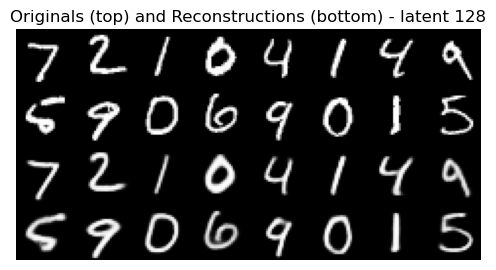

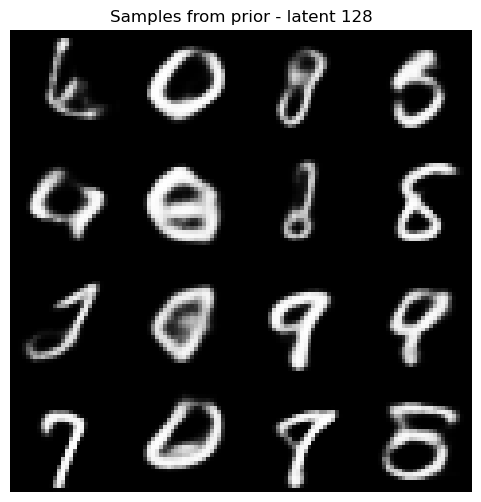

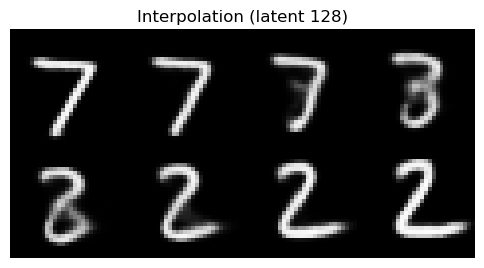

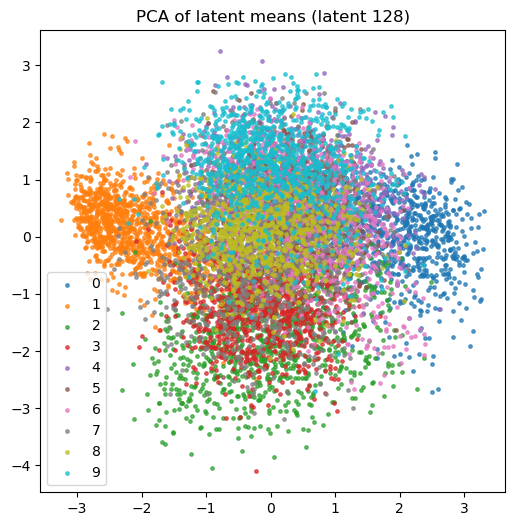

Params: 1789761
Epoch 1/50 — loss: 201.6830 — BCE: 187.3607 — KLD: 14.3222
Epoch 2/50 — loss: 137.0431 — BCE: 111.4471 — KLD: 25.5960
Epoch 3/50 — loss: 117.5372 — BCE: 92.2900 — KLD: 25.2472
Epoch 4/50 — loss: 111.3541 — BCE: 86.0383 — KLD: 25.3158
Epoch 5/50 — loss: 108.3378 — BCE: 82.9137 — KLD: 25.4241
Epoch 6/50 — loss: 106.4798 — BCE: 80.9395 — KLD: 25.5403
Epoch 7/50 — loss: 105.2095 — BCE: 79.6733 — KLD: 25.5362
Epoch 8/50 — loss: 104.3214 — BCE: 78.7783 — KLD: 25.5430
Epoch 9/50 — loss: 103.6183 — BCE: 78.0920 — KLD: 25.5264
Epoch 10/50 — loss: 103.1142 — BCE: 77.5812 — KLD: 25.5329
Epoch 11/50 — loss: 102.5612 — BCE: 77.0813 — KLD: 25.4799
Epoch 12/50 — loss: 102.2005 — BCE: 76.7365 — KLD: 25.4640
Epoch 13/50 — loss: 101.8528 — BCE: 76.4429 — KLD: 25.4099
Epoch 14/50 — loss: 101.5293 — BCE: 76.1381 — KLD: 25.3912
Epoch 15/50 — loss: 101.2005 — BCE: 75.9006 — KLD: 25.2998
Epoch 16/50 — loss: 100.9622 — BCE: 75.6810 — KLD: 25.2811
Epoch 17/50 — loss: 100.7111 — BCE: 75.4372 — K

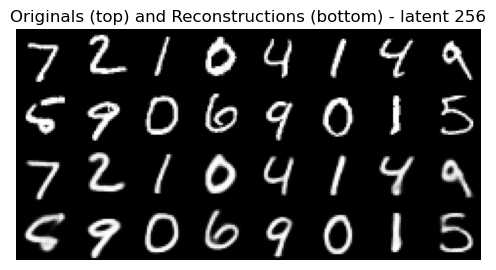

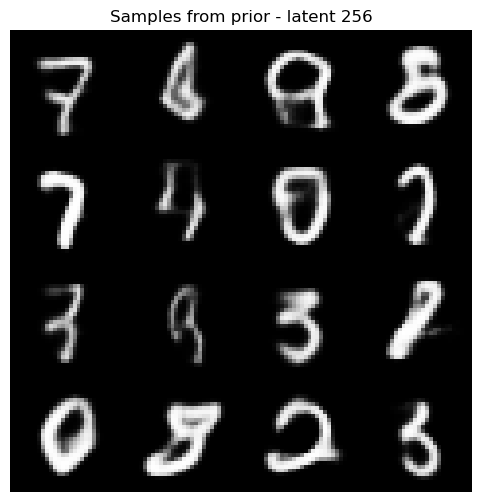

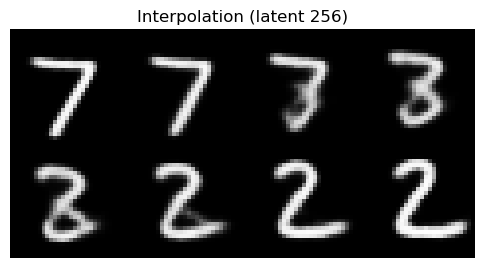

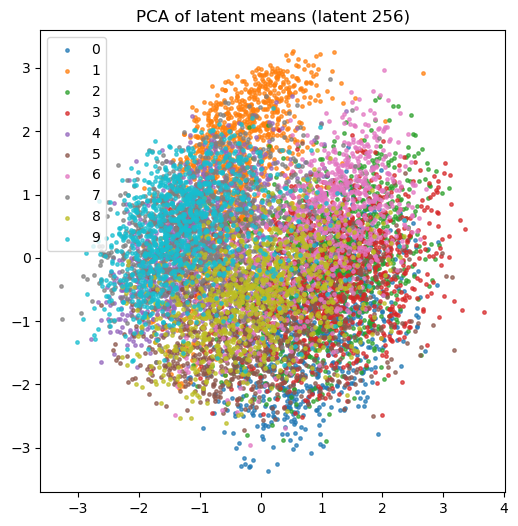

Saved sample grids to: ./vae_mnist_outputs


In [6]:
EPOCHS_DEMO_128 = 50   
EPOCHS_DEMO_256 = 50  

# Train latent_dim=128
model128 = ConvVAE(latent_dim=128)
print("Params:", sum(p.numel() for p in model128.parameters()))
model128, hist128 = train_vae(model128, train_loader, epochs=EPOCHS_DEMO_128, lr=1e-3, recon_type='bce', save_prefix='vae128_demo')

# Visualize results for 128
reconstruct_and_show(model128, n=16)
sample_and_show(model128, n=16)
interpolate_and_show(model128, steps=8)
latent_pca_plot(model128)

# Train latent_dim=256 
model256 = ConvVAE(latent_dim=256)
print("Params:", sum(p.numel() for p in model256.parameters()))
model256, hist256 = train_vae(model256, train_loader, epochs=EPOCHS_DEMO_256, lr=1e-3, recon_type='bce', save_prefix='vae256_demo')

# Visualize results for 256
reconstruct_and_show(model256, n=16)
sample_and_show(model256, n=16)
interpolate_and_show(model256, steps=8)
latent_pca_plot(model256)

# Save some sample grids to OUT_DIR
with torch.no_grad():
    s = torch.randn(64, 128).to(device)
    imgs = model128.decode(s)
    plt.imsave(os.path.join(OUT_DIR, "samples_latent128.png"), make_grid_from_tensor(imgs, nrow=8), cmap='gray')
    s2 = torch.randn(64, 256).to(device)
    imgs2 = model256.decode(s2)
    plt.imsave(os.path.join(OUT_DIR, "samples_latent256.png"), make_grid_from_tensor(imgs2, nrow=8), cmap='gray')

print("Saved sample grids to:", OUT_DIR)
